In [1]:
from PIL import Image, ImageDraw
import cv2
import numpy as np
from dmap import CLIP

def softmax(x):
    e_x = np.exp(x - np.max(x))  # 안정성을 위해 입력에서 최대값을 뺌
    return e_x / e_x.sum(axis=0)

def image_text_match(cropped_objects, text_query):
    image_features = clip.encode_images(cropped_objects)
    if isinstance(text_query, str): text_query = [text_query]
    text_features = clip.encode_text(text_query)
    probs = 100. * clip.similarity(image_features, text_features)
    return softmax(probs)

def get_bbox(segment_mask):
    return [np.min(np.where(segment_mask)[1]), np.min(np.where(segment_mask)[0]), 
            np.max(np.where(segment_mask)[1]), np.max(np.where(segment_mask)[0])]

def crop_image(image, segment_mask):
    # bbox = [xyxy]
    x0, y0, x1, y1 = get_bbox(segment_mask)
    cropped_image = image[y0:y1, x0:x1]
    return cropped_image

def apply_gray_bg(image_array, segment_mask):
    gray_image = np.ones_like(image_array) * 128
    gray_image[segment_mask] = image_array[segment_mask]
    return gray_image

def mobilesam(image):
    image_dir = f"./{image}_annotated.png"
    segment = cv2.imread(image_dir)
    return segment

def get_cropped_images(image, segment):
    unique_colors = np.unique(segment.reshape(-1, segment.shape[2]), axis=0)
    # remove white
    unique_colors = unique_colors[~np.all(unique_colors == [255, 255, 255], axis=1)]
    cropped_images = []
    binary_masks = []
    for color in unique_colors:
        r, g, b = color
        binary_mask = np.all(segment == [r, g, b], axis=-1)
        binary_masks.append(binary_mask)
        cropped_image = crop_image(apply_gray_bg(image, binary_mask), binary_mask)
        cropped_images.append(cropped_image)
    return cropped_images, binary_masks

def get_id_photo_output(image, text, segmented_image, get_all=True):
    """
    Get the special size and background photo.

    Args:
        img(numpy:ndarray): The image array.
        size(str): The size user specified.
        bg(str): The background color user specified.
        download_size(str): The size for image saving.

    """
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_images, binary_masks = get_cropped_images(image, segmented_image)
    scores = image_text_match(cropped_images, str(text))
    text_matching_masks = []
    print(scores)
    if get_all:
        for idx, score in enumerate(scores):
            if score < 0.05:
                continue
            text_matching_mask = binary_masks[idx]
            text_matching_masks.append(text_matching_mask)
    else: # get the highest score
        max_score_idx = np.argmax(scores)
        if scores[max_score_idx] > 0.05:
            text_matching_masks.append(binary_masks[max_score_idx])
    result_image = np.copy(image)
    for text_matching_mask in text_matching_masks:
        # apply red mask with 20% transparency
        result_image[text_matching_mask] = (result_image[text_matching_mask] * 0.1 + 
                                            np.array([255, 0, 0]) * 0.9).astype(np.uint8)
    return result_image, text_matching_masks

/home/jet/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.01940807 0.00871009 0.46062618 0.08449678 0.02561278 0.044298
 0.08467485 0.27217326]


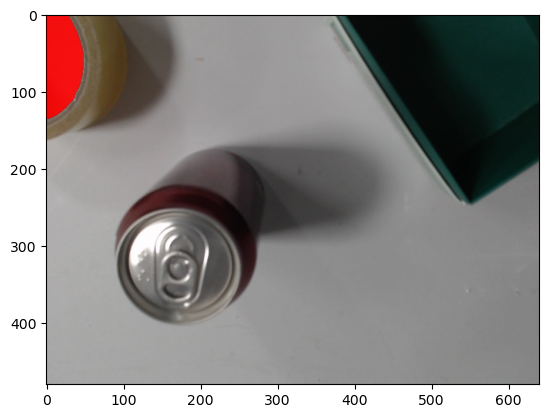

In [ ]:
clip = CLIP()
img = cv2.imread('./test_images/3.jpg')
segment_image = mobilesam('3')
result_image, text_matching_masks = get_id_photo_output(img, 'asdfasef', segment_image, get_all=False)
import matplotlib.pyplot as plt
plt.imshow(result_image)
plt.show()

In [11]:
clip = CLIP()
img = cv2.imread('./test_images/17.png')
seg_img = cv2.imread('./segment/17.png')
result_image, binary_masks = get_id_photo_output(img, 'fire extinguisher', seg_img, get_all=False)
# binary mask to RGB image
binary_masks = np.array(binary_masks).astype(np.uint8)[0] * 255
print(binary_masks.shape)
binary_masks = cv2.cvtColor(binary_masks, cv2.COLOR_GRAY2BGR)
cv2.imwrite('binary_masks.png', binary_masks)

[2.53906797e-07 9.77604782e-01 1.06755709e-07 5.19947643e-06
 4.15388252e-04 8.20962968e-07 3.33844988e-06 2.12676683e-02
 3.87217805e-05 9.53501423e-09 1.42431088e-06 4.45964239e-06
 1.53756453e-04 2.84293723e-08 1.99409593e-07 5.03842272e-04]
(576, 341)


True